#################################################################################################
## STEP (1)
##### The following code is used to create a control csv file. The control file specifies which
##### articles are in the training set, along with their respective coding, and which articles are 
#####  in the test set. The csv file you read in should contain the ratings of the human coders and ## follow the same formatting as the example template. The code will aggregate and average the 
##### ratings for each article. You can specify which question you want to code the article by.
##### Remember to create new control files for each question type, and whenever you change which
#####  articles are contained in the training set.
#################################################################################################

In [ ]:
import numpy as np
import pandas as pd
import os

In [ ]:
#Specify full set of articles
filenames=list()
for root, dirs, files in os.walk(r"C:\Users\PUSHPENDRA\Desktop\Acads\Autumn 2017-18\snlp\open data\6. News articles"):
    for file in files:
        filenames.append(file)
        print(file)
filedat=pd.DataFrame(filenames)


In [ ]:
# specify which coding document to use - complete list of human coders' responses
# must be in correct format, otherwise errors will occur below
dat=pd.read_csv(r"C:\Users\PUSHPENDRA\Desktop\Acads\Autumn 2017-18\snlp\open data\Pandemics_Response.csv") 
dat

In [ ]:
# function that averages human coders' inputs and creates a control .csv file
def average_score(col,filename=""):
    dat_agg=pd.DataFrame()
    dat_agg=dat.groupby('Newsarticle', as_index=False).mean()
    
    #print(dat_agg)
    # pad article name with zeros so that it matches text file
    dat_agg['Article_pad']=""
    for i in range(231):
        
        dat_agg['Article_pad'][i]= dat_agg['Newsarticle'][i][:9]+".docx"
    # specify training articles
    dat_agg['Train']= 1
    dat_agg["Train"][200:]=0
    
    # ignore blank cells
    ##dat_agg.dropna()
    #control=pd.DataFrame()
    #control=pd.concat([filedat,dat_agg])
    
    ROWID=dat_agg["Article_pad"]
    TRUTH=dat_agg[col]
    TRAININGSET=dat_agg["Train"]

    control=pd.DataFrame()
    control=pd.concat([ROWID,TRUTH,TRAININGSET],axis=1)
    
    control.fillna(0)
    control.columns=["ROWID","TRUTH", "TRAININGSET"]
    print(control)
    path=r"C:\Users\PUSHPENDRA\Desktop\Acads\Autumn 2017-18\snlp\open data"
    control.to_csv(os.path.join(path,filename))
    

    
    
    
average_score("1", filename = "control_elig_500.docx")
average_score("2", filename = "control_A6_200.docx")
average_score("3", filename = "control_B12_MMNN.docx")



### STEP2
#### The following code is to copy and paste certain files that you want into new folders. You will 
#### need to specify and create the folders you want to add files to. You can 1) create a folder of 
#### just training documents, 2) rename the training documents with "training" in front, 3) set up 
#### a random sample of articles, 4) copy files of a certain length to a new folder, 5) copy 
#### eligible files into a new folder 6) or read in a list of files to copy to a new folder. Only 
#### use which functions you need. In general, you will have to set up new training files when you 
#### start a new task, and copy the eligible files over to a new folder after you do the first 
#### round of MaxEnt.


In [ ]:
# specify which control file you are using in order to build a subset of the training files
train_info = pd.read_csv(r"C:\Users\PUSHPENDRA\Desktop\Acads\Autumn 2017-18\snlp\open data\control_A6_200.docx")

# set up subset with just training documents
# only necessary when you add or subtract articles from the training set 
import shutil
import os
count=0
for i in train_info[train_info["TRAININGSET"] == 1]["ROWID"]:
    count+=1
    path=r"C:\Users\PUSHPENDRA\Desktop\Acads\Autumn 2017-18\snlp\open data\6. News articles"
    dest=r"C:\Users\PUSHPENDRA\Desktop\Acads\Autumn 2017-18\snlp\open data\Training"
    src=os.path.join(path,i)
    dest1=os.path.join(dest,i)
    
    shutil.copyfile(src,dest1)
    
# rename training set files - add "training" to beginning of file name
# only necessary when you change articles in training set 
training_dir=r"C:\Users\PUSHPENDRA\Desktop\Acads\Autumn 2017-18\snlp\open data\Training"
filenames_training = os.listdir(training_dir)

files = os.listdir(training_dir)

for file in files:
    os.rename(os.path.join(training_dir, file),os.path.join(training_dir, "Training-"+file))

# now copy these files into big corpus folder

# set up a random sampling of articles from the larger set
# useful if you want to test before running MaxEnt of a huge number of articles
#filenames_test <- list.files("/home/steven/longer_lexis/") # full folder of articles
#filenames_samp <- sample(filenames_test, size = 10000)
#setwd("/home/steven/lexis/")
#file.copy(from = filenames_samp, to = "/home/steven/10thous/") # destination of subset
        
          





In [ ]:
# copy files that are longer than a certain length into a new folder
import codecs
import sys
cutoff= 500 #needs to be more than this number of characters
origin_folder=r"C:\Users\PUSHPENDRA\Desktop\Acads\Autumn 2017-18\snlp\open data\6. News articles"

destination_folder =r"C:\Users\PUSHPENDRA\Desktop\Acads\Autumn 2017-18\snlp\open data\longer_lexis"
def getUnicodeFileLength(filepath, charset= None):
    if charset is None:
        charset= sys.getfilesystemencoding()
    readerclass= codecs.getreader(charset)
    reader= readerclass(open(filepath, 'rb'), 'replace')
    nchar= 0
    while True:
        chars= reader.read(1024*32)  # arbitrary chunk size
        if chars=='':
            break
        nchar+= len(chars)
    reader.close()
    return nchar

files=os.listdir(origin_folder)  
for file in files:
    nchar=getUnicodeFileLength(os.path.join(origin_folder,file))
    if nchar  > cutoff :
        shutil.copyfile(os.path.join(origin_folder,file),os.path.join(destination_folder,file))  
  


##### STEP (3)
##### The following code is to run the MaxEnt model. Be sure to specify which control file to use,
##### which file to read from (file contains all training articles - renamed with "training" in
##### title - and all test articles). Remember that control files will be different for step 1 and
##### step 2 of MaxEnt - eligibility step contains more training articles, but step 2 will only be
##### using articles that are already eligible. Also specify what to call csv file where outputs are
##### written. You can turn different options on/off for cleaning corpus, depending on what type of
##### results you want.

In [ ]:
# Converting docs to text format such that we can apply nltk tools for text mining purpose.

import os,pandas as pd
import nltk
import os
import win32com.client
import nltk
from nltk.corpus import PlaintextCorpusReader
 
path=r"C:\Users\PUSHPENDRA\Desktop\Acads\Autumn 2017-18\snlp\open data\6. News articles"

def docxtotxt(file,filepath):
    doc = win32com.client.GetObject(filepath)
    text = doc.Range().Text
    #
    # do something with the text...
    #
    name=file[0:9]+".txt"

    newpath=r"C:\Users\PUSHPENDRA\Desktop\Acads\Autumn 2017-18\snlp\open data\Text_News_articles"
    f= open(os.path.join(newpath,name),"w+")
    f.write(text)
    f.close()
for file in os.listdir(path):
    docxtotxt(file,os.path.join(path,file))

#### Creating corpus


In [7]:
import nltk
from nltk.corpus import PlaintextCorpusReader
corpus_root = r"C:\Users\PUSHPENDRA\Desktop\Acads\Autumn 2017-18\snlp\open data\Text_News_articles"
newcorpus = PlaintextCorpusReader(corpus_root, '.*')

#### Cleaning Corpus

In [8]:
files=newcorpus.fileids()
print(newcorpus)
import re,os
import string
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer


def clean_corpus(file):


    f=open(file,'rb')
    file_content=f.read().decode('utf8', 'ignore')
    
    file_content = re.sub("\d+", "", file_content) #removing numbers from text
    
    
    tokens=nltk.word_tokenize(file_content)
    f.close()
    regex = re.compile('[%s]' % re.escape(string.punctuation)) #see documentation here: http://docs.python.org/2/library/string.html

    tokenized_docs_no_punctuation = []

    for token in tokens:
    
        new_review = []
        
        new_token = regex.sub(u'', token)
        if not new_token == u'':
                new_review.append(new_token)
        
        tokenized_docs_no_punctuation.append(new_review)
    


    tokenized_docs_no_stopwords = []
    for doc in tokenized_docs_no_punctuation:
        new_term_vector = []
        for word in doc:
            if not word in stopwords.words('english'):
                new_term_vector.append(word)
        tokenized_docs_no_stopwords.append(new_term_vector)
            
    porter = PorterStemmer()
    snowball = SnowballStemmer('english')
    wordnet = WordNetLemmatizer()
    # stem words 

    # stemming using Snowball package (or SnowballC)

    preprocessed_docs = []

    for doc in tokenized_docs_no_stopwords:
        final_doc = []
        for word in doc:
            #final_doc.append(porter.stem(word))
            final_doc.append(snowball.stem(word))
            #final_doc.append(wordnet.lemmatize(word)) #note that lemmatize() can also takes part of speech as an argument!
        preprocessed_docs.append(final_doc)

    #print(preprocessed_docs)

    text=nltk.Text(preprocessed_docs)
    mytext = ''.join(map(str, text))
    mytext= mytext.translate(str.maketrans(' ', ' ', "!@#$[]"))
    mytext=mytext.replace("''"," ")

    path=r"C:\Users\PUSHPENDRA\Desktop\Acads\Autumn 2017-18\snlp\open data\clean_corpus"
    
    newfile=open(os.path.join(path,file[83:]),'w+')
    newfile.write(mytext)
    newfile.close()

    
    
    
for file in files:
    clean_corpus(os.path.join(corpus_root,file))

<PlaintextCorpusReader in 'C:\\Users\\PUSHPENDRA\\Desktop\\Acads\\Autumn 2017-18\\snlp\\open data\\Text_News_articles'>


#### Creating cleaning corpus


In [2]:
import nltk
from nltk.corpus import PlaintextCorpusReader
root = r"C:\Users\PUSHPENDRA\Desktop\Acads\Autumn 2017-18\snlp\open data\clean_corpus"
cleancorpus = PlaintextCorpusReader(root, '.*')
files=cleancorpus.fileids()
len(files)


652

In [3]:
import pandas as pd
import os 
import numpy as np
import pandas as pd
from nltk.classify import MaxentClassifier
from sklearn.linear_model import LogisticRegression as logreg
from sklearn import metrics
from nltk.classify.maxent import MaxentClassifier as maxent
files=cleancorpus.fileids()
docs=[] #all words in corpus
# create a control list for the DocumentTermMatrix function
min_wordlength=4
max_wordlength=20
minDocfreq=15

#Traversing through every file in corpus 
vocab=r"C:\Users\PUSHPENDRA\Desktop\Acads\Autumn 2017-18\snlp\open data\Vocabulary\Vocab_clean.txt"
for word in open(vocab).readlines():
    vocabulary=word.split() 
'''    
for file in files:
    f=open(os.path.join(root,file))
    file_content=f.read()
    
    

    tokens=nltk.word_tokenize(file_content)
    docs+=tokens
   
'''
from sklearn.feature_extraction.text import CountVectorizer 

def fn_tdm_df(vocab,docs, xColNames = None):
    ''' create a term document matrix as pandas DataFrame
    with **kwargs you can pass arguments of CountVectorizer
    if xColNames is given the dataframe gets columns Names'''

    #initialize the  vectorizer
    vectorizer = CountVectorizer(min_df=1,vocabulary=vocab)
    x1 = vectorizer.fit_transform(docs)
    #create dataFrame
    df = pd.DataFrame(x1.toarray().transpose(), index = vectorizer.get_feature_names())
    if xColNames is not None:
        df.columns = xColNames

    return df

DIR = root
DIR_V=r"C:\Users\PUSHPENDRA\Desktop\Acads\Autumn 2017-18\snlp\open data\Vocabulary"
def fn_CorpusFromDIR(xDIR):
    ''' functions to create corpus from a Directories
    Input: Directory
    Output: A dictionary with 
             Names of files ['ColNames']
             the text in corpus ['docs']'''
    import os
    Res = dict(docs = [open(os.path.join(DIR,f)).read() for f in os.listdir(DIR)],
               ColNames = map(lambda x: 'P_' + x[0:6], os.listdir(xDIR)))
    return Res
d1 = fn_tdm_df(vocabulary,docs = fn_CorpusFromDIR(DIR)['docs'],
          xColNames = fn_CorpusFromDIR(DIR)['ColNames'])  


	
# specify which coding document to use - complete list of human coders' responses
# must be in correct format, otherwise errors will occur below
dat=pd.read_csv(r"C:\Users\PUSHPENDRA\Desktop\Acads\Autumn 2017-18\snlp\open data\Exaggeration.csv")

d=d1.T.as_matrix(columns=None)
label=dat.as_matrix(columns=None)
label=np.delete(label, [0], axis=1)
d1.to_csv(r"C:\Users\PUSHPENDRA\Desktop\Acads\Autumn 2017-18\snlp\open data\dtm.csv")
model=logreg()
FS=dat['Advice'][:450]
model.fit(d[:450],FS)
preds =model.predict(X=d[451:])
pd.crosstab(preds,dat['Advice'][451:])
print(model.score(d[451:],dat['Advice'][451:]))
print(metrics.classification_report(y_true=dat['Advice'][451:],y_pred=preds) )
d1

0.771144278607
             precision    recall  f1-score   support

          0       0.80      0.94      0.87       160
          1       0.31      0.10      0.15        41

avg / total       0.70      0.77      0.72       201



,P_01-11-,P_01-11-,P_01-11-,P_01-11-,P_01-11-,P_01-11-,P_01-11-,P_01-11-,P_01-11-,P_01-11-,...,P_20-11-,P_20-11-,P_20-11-,P_20-11-,P_20-11-,P_20-11-,P_20-11-,P_20-11-,P_20-11-,P_20-11-
reduc,0,2,0,1,0,0,1,0,0,0,...,0,1,0,0,0,0,0,1,0,1
skyrocket,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
immedi,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
immin,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
doubt,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
uncertain,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
indecis,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
perplex,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
embarrass,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
hesit,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Similarily for Press Release

In [ ]:
# Converting docs to text format such that we can apply nltk tools for text mining purpose.

import os,pandas as pd
import nltk
import os
import win32com.client
import nltk
import io
from nltk.corpus import PlaintextCorpusReader
 
path1=r"C:\Users\PUSHPENDRA\Desktop\Acads\Autumn 2017-18\snlp\open data\5. Press releases"

def docxtotxt(file,filepath):
    doc = win32com.client.GetObject(filepath)
    text = doc.Range().Text
    #
    # do something with the text...
    #
    name=file[0:9]+".txt"

    #newpath=r"C:\Users\PUSHPENDRA\Desktop\Acads\Autumn 2017-18\snlp\open data\Text_Press_releases"
    #f= open(os.path.join(newpath,name),"w+")
    #f.write(text)
    #f.close()
for file in os.listdir(path1):
    docxtotxt(file,os.path.join(path1,file))

In [84]:
import nltk
from nltk.corpus import PlaintextCorpusReader
corpus_root = r"C:\Users\PUSHPENDRA\Desktop\Acads\Autumn 2017-18\snlp\open data\Text_Press_releases"
newcorpus_press = PlaintextCorpusReader(corpus_root, '.*')
files=newcorpus_press.fileids()
len(files)

462

#### Cleaning Press releases corpus

In [7]:
files=newcorpus_press.fileids()
import re,os
import string
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer


def clean_corpus(file):


    f=open(file,'rb')
    file_content=f.read().decode('utf8', 'ignore')
    
    file_content = re.sub("\d+", "", file_content) #removing numbers from text
    
    
   
    
    tokens=nltk.word_tokenize(file_content)
    f.close()
    regex = re.compile('[%s]' % re.escape(string.punctuation)) #see documentation here: http://docs.python.org/2/library/string.html

    tokenized_docs_no_punctuation = []

    for token in tokens:
    
        new_review = []
        
        new_token = regex.sub(u'', token)
        if not new_token == u'':
                new_review.append(new_token)
        
        tokenized_docs_no_punctuation.append(new_review)
    


    tokenized_docs_no_stopwords = []
    for doc in tokenized_docs_no_punctuation:
        new_term_vector = []
        for word in doc:
            if not word in stopwords.words('english'):
                new_term_vector.append(word)
        tokenized_docs_no_stopwords.append(new_term_vector)
            
    porter = PorterStemmer()
    snowball = SnowballStemmer('english')
    wordnet = WordNetLemmatizer()
    # stem words 

    # stemming using Snowball package (or SnowballC)

    preprocessed_docs = []

    for doc in tokenized_docs_no_stopwords:
        final_doc = []
        for word in doc:
            #final_doc.append(porter.stem(word))
            final_doc.append(snowball.stem(word))
            #final_doc.append(wordnet.lemmatize(word)) #note that lemmatize() can also takes part of speech as an argument!
        preprocessed_docs.append(final_doc)

    # print(preprocessed_docs)

    text=nltk.Text(preprocessed_docs)
    mytext = ''.join(map(str, text))
    mytext= mytext.translate(str.maketrans(' ', ' ', "!@#$[]"))
    mytext=mytext.replace("''"," ")

    path=r"C:\Users\PUSHPENDRA\Desktop\Acads\Autumn 2017-18\snlp\open data\clean_presscorpus"
    
    newfile=open(os.path.join(path,file[-13:]),'w+')
    newfile.write(mytext)
    newfile.close()
    
    
    
  
for file in files:
    clean_corpus(os.path.join(corpus_root,file))

####  Converting docs of cleaned corpus of News Articles into vector form

In [1]:
#Import all the dependencies
import gensim,os
from nltk import RegexpTokenizer
from nltk.corpus import stopwords
from os import listdir
from os.path import isfile, join

docLabels = []
docLabels = [f for f in listdir(r"C:\Users\PUSHPENDRA\Desktop\Acads\Autumn 2017-18\snlp\open data\Corpus") 
             if f.endswith(".txt")]
#create a list data that stores the content of all text files in order of their names in docLabels
data = []
for doc in docLabels:
    data.append(open(os.path.join(r"C:\Users\PUSHPENDRA\Desktop\Acads\Autumn 2017-18\snlp\open data\Corpus", doc)).read())


C:\Users\PUSHPENDRA\Anaconda3\lib\site-packages\gensim\utils.py:862: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
from gensim.models.doc2vec import TaggedDocument
class LabeledLineSentence(object):
    def __init__(self, doc_list, labels_list):
        self.labels_list = labels_list
        self.doc_list = doc_list
    def __iter__(self):
        for idx, doc in enumerate(self.doc_list):
            yield TaggedDocument(doc.split(),[self.labels_list[idx]])

#iterator returned over all documents
it = LabeledLineSentence(data, docLabels)

In [3]:
model = gensim.models.Doc2Vec(size=300, min_count=0, alpha=0.025, min_alpha=0.025)
model.build_vocab(it)
#training of model
for epoch in range(10):
    print('iteration' +str(epoch+1))
    model.train(it,total_examples=model.corpus_count,epochs=model.iter)
    model.alpha -= 0.002
    model.min_alpha = model.alpha
    model.train(it,total_examples=model.corpus_count,epochs=model.iter)
#saving the created model
print("Iteration Completed")

iteration1
iteration2
iteration3
iteration4
iteration5
iteration6
iteration7
iteration8
iteration9
iteration10
Iteration Completed


In [30]:
#loading the model
from sklearn.metrics.pairwise import cosine_similarity
model.save("doc2vec.model")
d2v_model = gensim.models.doc2vec.Doc2Vec.load('doc2vec.model')
print("model saved")

model saved


#### Cosine Similarity for FS Exaggerated and Non Exaggerated articles

In [ ]:
import pandas as pd 
import csv
news=pd.read_csv(r"C:\Users\PUSHPENDRA\Desktop\Acads\Autumn 2017-18\snlp\open data\Exaggeration_new.csv")
news_ex=news[news['Exaggeration']==1]
news_nonex=news[news['Exaggeration']==0]
d2v_model = gensim.models.doc2vec.Doc2Vec.load('doc2vec.model')
#Cosine Similarity for Exaggerated News Articles
i=0
tot=0
with open(r"C:\Users\PUSHPENDRA\Desktop\Acads\Autumn 2017-18\snlp\open data\cosine.csv",'a') as f:
    writer = csv.writer(f, dialect='excel')
    for index,file in news_ex.iterrows():
        press=file[0][:6]+'0'+file[0][8:]+".txt"
        newsarticle=file[0][:6]+'0'+file[0][8:]+"_"+file[1]+".txt"
       
        docvec = d2v_model.docvecs[press]#if string tag used in training
        docvec1= d2v_model.docvecs[newsarticle]
        sim=cosine_similarity(docvec,docvec1)[0][0]
        writer.writerow([press,newsarticle,1,sim])
        

            
with open(r"C:\Users\PUSHPENDRA\Desktop\Acads\Autumn 2017-18\snlp\open data\cosine.csv",'a') as f:
    writer = csv.writer(f, dialect='excel')
    for index,file in news_nonex.iterrows():

        press=file[0][:6]+'0'+file[0][8:]+".txt"
        newsarticle=file[0][:6]+'0'+file[0][8:]+"_"+file[1]+".txt"
        docvec = d2v_model.docvecs[press]#if string tag used in training
        docvec1= d2v_model.docvecs[newsarticle]
        sim=cosine_similarity(docvec,docvec1)[0][0]
        tot=tot+sim
        writer.writerow([press,newsarticle,0,sim])
  

In [ ]:
news_fsexag=news[news['FS']==1]
news_fsnonexag=news[news['FS']!=1]
i=0
with open(r"C:\Users\PUSHPENDRA\Desktop\Acads\Autumn 2017-18\snlp\open data\cosine_FSexaggeration.csv",'w') as f:
    writer = csv.writer(f, dialect='excel')
    for index,file in news_fsexag.iterrows():
        press=file[0][:6]+'0'+file[0][8:]+".txt"
        newsarticle=file[0][:6]+'0'+file[0][8:]+"_"+file[1]+".txt"
        i=i+1
        docvec = d2v_model.docvecs[press]#if string tag used in training
        docvec1= d2v_model.docvecs[newsarticle]
        sim=cosine_similarity(docvec,docvec1)[0][0]
        writer.writerow([press,newsarticle,1,sim])
with open(r"C:\Users\PUSHPENDRA\Desktop\Acads\Autumn 2017-18\snlp\open data\cosine_FSexaggeration.csv",'a') as f:
    writer = csv.writer(f, dialect='excel')

    for index,file in news_fsnonexag.iterrows():

        press=file[0][:6]+'0'+file[0][8:]+".txt"
        newsarticle=file[0][:6]+'0'+file[0][8:]+"_"+file[1]+".txt"
        docvec = d2v_model.docvecs[press]#if string tag used in training
        docvec1= d2v_model.docvecs[newsarticle]
        sim=cosine_similarity(docvec,docvec1)[0][0]
        writer.writerow([press,newsarticle,0,sim])

#### Cosine Similarity for advice exaggerated and Non exagerated

In [ ]:
news_advex=news[news['Advice']==1]
news_advnonex=news[news['Advice']!=1]

i=0
with open(r"C:\Users\PUSHPENDRA\Desktop\Acads\Autumn 2017-18\snlp\open data\cosine_Advice_exaggeration.csv",'w') as f:
    writer = csv.writer(f, dialect='excel')
    for index,file in news_advex.iterrows():
        press=file[0][:6]+'0'+file[0][8:]+".txt"
        newsarticle=file[0][:6]+'0'+file[0][8:]+"_"+file[1]+".txt"
        i=i+1
        docvec = d2v_model.docvecs[press]#if string tag used in training
        docvec1= d2v_model.docvecs[newsarticle]
        sim=cosine_similarity(docvec,docvec1)[0][0]
        writer.writerow([press,newsarticle,1,sim])


with open(r"C:\Users\PUSHPENDRA\Desktop\Acads\Autumn 2017-18\snlp\open data\cosine_Advice_exaggeration.csv",'a') as f:
    writer = csv.writer(f, dialect='excel')
    for index,file in news_advnonex.iterrows():

        press=file[0][:6]+'0'+file[0][8:]+".txt"
        newsarticle=file[0][:6]+'0'+file[0][8:]+"_"+file[1]+".txt"
        docvec = d2v_model.docvecs[press]#if string tag used in training
        docvec1= d2v_model.docvecs[newsarticle]
        sim=cosine_similarity(docvec,docvec1)[0][0]
        writer.writerow([press,newsarticle,0,sim])

#### Cosine Similarity for Sample exaggerated and Non exagerated

In [ ]:
news_sampex=news[news['Sample']==1]
news_sampnonex=news[news['Sample']!=1]

i=0
with open(r"C:\Users\PUSHPENDRA\Desktop\Acads\Autumn 2017-18\snlp\open data\cosine_Sample_exaggeration.csv",'w') as f:
    writer = csv.writer(f, dialect='excel')
    for index,file in news_sampex.iterrows():
        press=file[0][:6]+'0'+file[0][8:]+".txt"
        newsarticle=file[0][:6]+'0'+file[0][8:]+"_"+file[1]+".txt"
        i=i+1
        docvec = d2v_model.docvecs[press]#if string tag used in training
        docvec1= d2v_model.docvecs[newsarticle]
        sim=cosine_similarity(docvec,docvec1)[0][0]
        writer.writerow([press,newsarticle,1,sim])


with open(r"C:\Users\PUSHPENDRA\Desktop\Acads\Autumn 2017-18\snlp\open data\cosine_Sample_exaggeration.csv",'a') as f:
    writer = csv.writer(f, dialect='excel')
    for index,file in news_sampnonex.iterrows():

        press=file[0][:6]+'0'+file[0][8:]+".txt"
        newsarticle=file[0][:6]+'0'+file[0][8:]+"_"+file[1]+".txt"
        docvec = d2v_model.docvecs[press]#if string tag used in training
        docvec1= d2v_model.docvecs[newsarticle]
        sim=cosine_similarity(docvec,docvec1)[0][0]
        writer.writerow([press,newsarticle,0,sim])

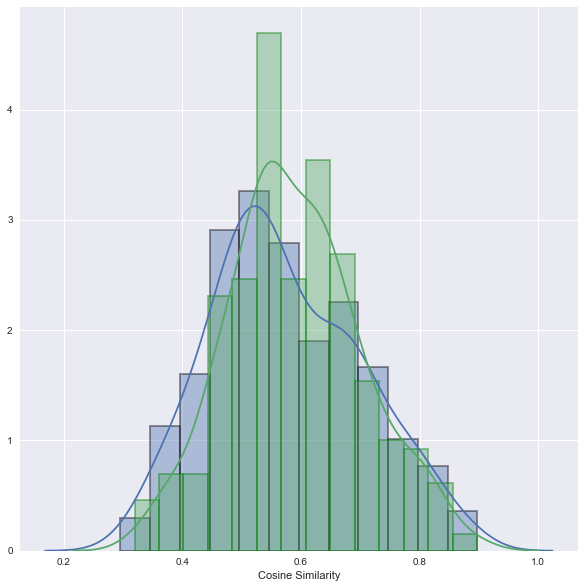

In [103]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

data = pd.read_csv(r"C:\Users\PUSHPENDRA\Desktop\Acads\Autumn 2017-18\snlp\open data\cosine.csv",dtype=float,usecols=(3,)) #loading 4th column of csv file into array named data. 

fig, ax = plt.subplots(figsize=(10,10),sharey=True)
new=data['Cosine Similarity'][:336]
new_nonex=data['Cosine Similarity'][336:][data['Cosine Similarity']>0]
sns.distplot(new, hist_kws=dict(edgecolor="k", linewidth=2),label="Exaggerated")
sns.distplot(new_nonex, hist_kws=dict(edgecolor="g", linewidth=2),label="Non-Exaggerated")
plt.savefig(r'C:\Users\PUSHPENDRA\Desktop\Acads\Autumn 2017-18\snlp\open data\Cosine.jpg')
plt.show()

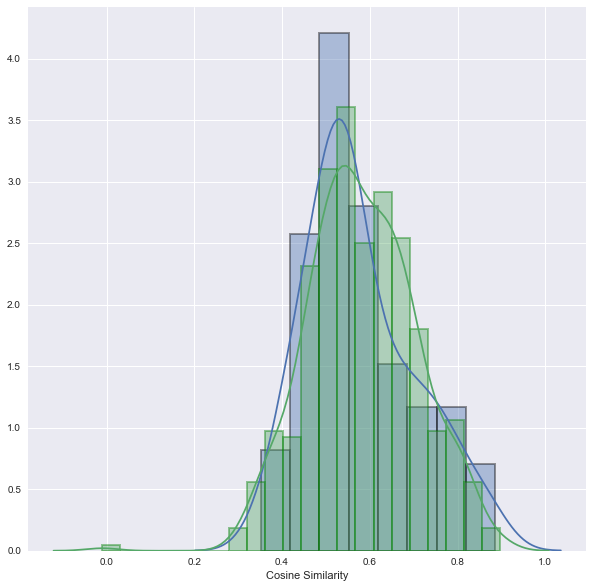

In [104]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

data = pd.read_csv(r"C:\Users\PUSHPENDRA\Desktop\Acads\Autumn 2017-18\snlp\open data\cosine_Advice_exaggeration.csv") #loading 4th column of csv file into array named data. 

fig, ax = plt.subplots(figsize=(10,10),sharey=True)
new=data['Cosine Similarity'][data['Advice_Exaggeration']==1]

new_nonex=data['Cosine Similarity'][data['Advice_Exaggeration']==0]
sns.distplot(new, hist_kws=dict(edgecolor="k", linewidth=2),label="Exaggerated")
sns.distplot(new_nonex, hist_kws=dict(edgecolor="g", linewidth=2),label="Non-Exaggerated")
plt.savefig(r'C:\Users\PUSHPENDRA\Desktop\Acads\Autumn 2017-18\snlp\open data\Cosine_Advice_Exaggeration.jpg')
plt.show()

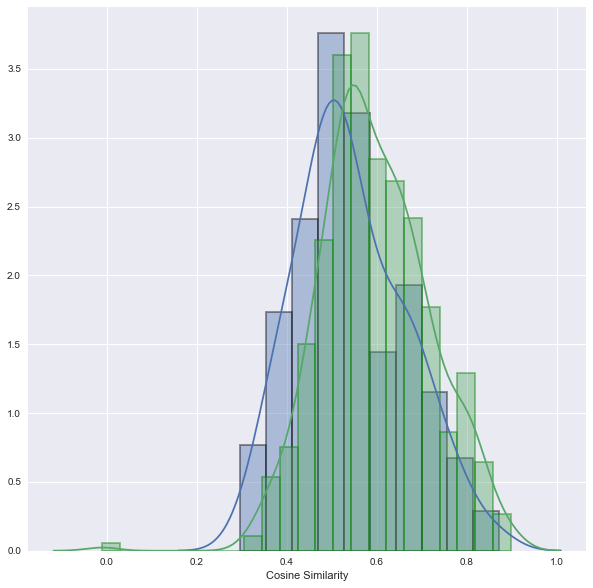

In [107]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

data = pd.read_csv(r"C:\Users\PUSHPENDRA\Desktop\Acads\Autumn 2017-18\snlp\open data\cosine_FSexaggeration.csv") #loading 4th column of csv file into array named data. 

fig, ax = plt.subplots(figsize=(10,10),sharey=True)
new=data['Cosine Similarity'][data['FS_exaggeration']==1]

new_nonex=data['Cosine Similarity'][data['FS_exaggeration']==0]
sns.distplot(new, hist_kws=dict(edgecolor="k", linewidth=2),label="Exaggerated")
sns.distplot(new_nonex, hist_kws=dict(edgecolor="g", linewidth=2),label="Non-Exaggerated")
plt.savefig(r'C:\Users\PUSHPENDRA\Desktop\Acads\Autumn 2017-18\snlp\open data\Cosine_FSexaggeration.jpg')
plt.show()

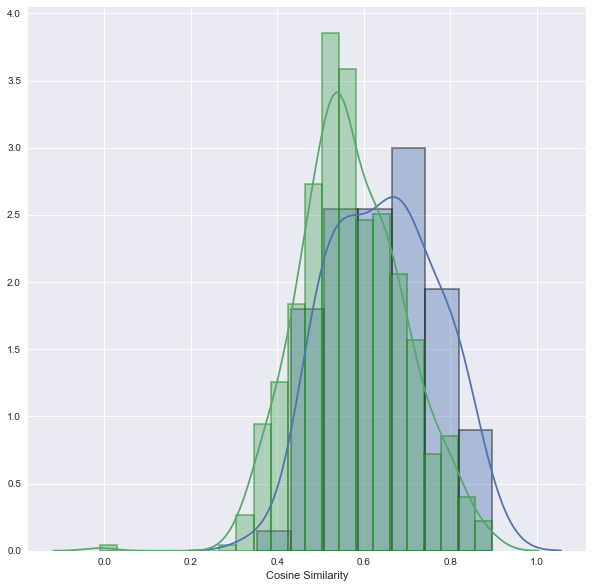

In [110]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

data = pd.read_csv(r"C:\Users\PUSHPENDRA\Desktop\Acads\Autumn 2017-18\snlp\open data\cosine_Sample_exaggeration.csv") #loading 4th column of csv file into array named data. 

fig, ax = plt.subplots(figsize=(10,10),sharey=True)
new=data['Cosine Similarity'][data['Sample_exaggeration']==1]

new_nonex=data['Cosine Similarity'][data['Sample_exaggeration']==0]
sns.distplot(new, hist_kws=dict(edgecolor="k", linewidth=2),label="Exaggerated")
sns.distplot(new_nonex, hist_kws=dict(edgecolor="g", linewidth=2),label="Non-Exaggerated")
plt.savefig(r'C:\Users\PUSHPENDRA\Desktop\Acads\Autumn 2017-18\snlp\open data\Cosine_Sample_exaggeration.jpg')
plt.show()

#### Analyzing other datsets

In [131]:
token='EAAVFiIe3NUIBAGTwdFm5n56QJzILX7Yvr7KR8GkTnn53biGzcr5EwtCeiA7nGaFRtRr6IVBrOZCei1bmU4YYgtlm1TebukrqOh9T8D7ryK4womGVMEShGuYy7dlnXhNCqGKOKfiuuNromVir0yeIVUv5AF7hNdOZAmUZALDgZBQKMm6UHMvmUVDFx603aWiVCPAJZBwY2dwZDZD'

In [132]:
import urllib3
import facebook

graph = facebook.GraphAPI(access_token=token, version=2.10)
post = graph.get_object(id='184096565021911_1035057923259100', fields='story')
print(post['story'])


ABC News Politics shared Good Morning America's video.


## Running Machine Learning Algorithms on input features as doc vectors

In [25]:
import pandas as pd 
import numpy as np
import csv
from sklearn.linear_model import LogisticRegression as logreg
from sklearn import metrics
news=pd.read_csv(r"C:\Users\PUSHPENDRA\Desktop\Acads\Autumn 2017-18\snlp\open data\Exaggeration_new.csv")
d2v_model = gensim.models.doc2vec.Doc2Vec.load('doc2vec.model')
i=0
feature=np.zeros(shape=(652,300))
feature_all=np.zeros(shape=(652,600))
for index,file in news.iterrows():
        press=file[0][:6]+'0'+file[0][8:]+".txt"
        newsarticle=file[0][:6]+'0'+file[0][8:]+"_"+file[1]+".txt"
       
        docvec = d2v_model.docvecs[press]#if string tag used in training
        docvec1= d2v_model.docvecs[newsarticle]
        tot=np.concatenate((docvec,docvec1))
        feature[i]=docvec1.T
        feature_all[i]=tot.T
    
        
        
        i=i+1

feature_df=pd.DataFrame(feature)
feature_all_df=pd.DataFrame(feature_all)
feature_df.to_csv(r"C:\Users\PUSHPENDRA\Desktop\Acads\Autumn 2017-18\snlp\open data\feature.csv")
feature_all_df.to_csv(r"C:\Users\PUSHPENDRA\Desktop\Acads\Autumn 2017-18\snlp\open data\feature_all.csv")

In [26]:
print(feature[0])

[ -5.87624252e-01  -1.24810982e+00  -3.80648345e-01   1.43174386e+00
  -1.02823436e+00   5.04723668e-01  -2.22158027e+00   6.21829629e-01
   1.89199492e-01  -1.34718406e+00  -3.47852260e-01   6.14132762e-01
  -2.01317596e+00   7.43881643e-01   6.74505293e-01  -4.52624917e-01
  -9.68875051e-01  -8.48520279e-01   8.07033405e-02  -1.00910544e+00
  -3.30144405e-01  -1.29717076e+00   2.60563517e+00   9.33609009e-01
  -2.86031151e+00   9.94192302e-01  -7.70316184e-01  -7.68248260e-01
  -2.62049168e-01  -2.62143898e+00   9.79904294e-01  -1.31102562e+00
  -2.32445657e-01  -6.93344712e-01   1.86231405e-01  -1.67043734e+00
  -1.63447487e+00  -1.18591642e+00   2.16381693e+00  -1.04858327e+00
   8.16839218e-01   6.92717582e-02  -6.97775841e-01   1.01728868e+00
  -3.25492954e+00   5.47282577e-01  -7.49145091e-01   3.37777197e-01
  -6.91581547e-01   7.23083198e-01   3.13893050e-01   6.96843386e-01
   2.05566660e-01   2.08569431e+00  -9.99843180e-02   1.58859771e-02
   5.70059754e-02   3.44743788e-01

### Logistic regression on feature vectors

In [27]:
dat=pd.read_csv(r"C:\Users\PUSHPENDRA\Desktop\Acads\Autumn 2017-18\snlp\open data\Exaggeration_new.csv")

model=logreg()
FS=dat['Advice'][:450]
model.fit(feature[:450],FS)
preds =model.predict(X=feature[451:])
pd.crosstab(preds,dat['Advice'][451:])
print("Accuracy: ")
print(model.score(feature[451:],dat['Advice'][451:]))
print()
print("classification_report :")
print( metrics.classification_report(y_true=dat['Advice'][451:],y_pred=preds) )


Accuracy: 
0.766169154229

classification_report :
             precision    recall  f1-score   support

          0       0.85      0.86      0.86       161
          1       0.41      0.38      0.39        40

avg / total       0.76      0.77      0.76       201



In [7]:
dat=dat=pd.read_csv(r"C:\Users\PUSHPENDRA\Desktop\Acads\Autumn 2017-18\snlp\open data\Exaggeration_new.csv")

model=logreg()
FS=dat['FS'][:450]
model.fit(feature[:450],FS)
preds =model.predict(X=feature[451:])
pd.crosstab(preds,dat['FS'][451:])
print("Accuracy: ")
print(model.score(feature[451:],dat['FS'][451:]))
print
print("classification_report :")
print( metrics.classification_report(y_true=dat['FS'][451:],y_pred=preds) )

Accuracy: 
0.706467661692

classification_report :
             precision    recall  f1-score   support

          0       0.82      0.78      0.80       149
          1       0.44      0.50      0.47        52

avg / total       0.72      0.71      0.71       201



In [8]:
dat=dat=pd.read_csv(r"C:\Users\PUSHPENDRA\Desktop\Acads\Autumn 2017-18\snlp\open data\Exaggeration_new.csv")

model=logreg()
FS=dat['Sample'][:450]
model.fit(feature[:450],FS)
preds =model.predict(X=feature[451:])
pd.crosstab(preds,dat['Sample'][451:])
print("Accuracy: ")
print(model.score(feature[451:],dat['Sample'][451:]))
print()
print("classification_report :")
print( metrics.classification_report(y_true=dat['Sample'][451:],y_pred=preds) )

Accuracy: 
0.870646766169

classification_report :
             precision    recall  f1-score   support

          0       0.91      0.94      0.93       172
          1       0.57      0.45      0.50        29

avg / total       0.86      0.87      0.86       201



In [35]:
dat=pd.read_csv(r"C:\Users\PUSHPENDRA\Desktop\Acads\Autumn 2017-18\snlp\open data\Exaggeration_new.csv")

model=logreg()
FS=dat['Exaggeration'][:450]
model.fit(feature[:450],FS)
preds =model.predict(X=feature[451:])
pd.crosstab(preds,dat['Exaggeration'][451:])
print("Accuracy: ")
print(model.score(feature[451:],dat['Exaggeration'][451:]))
print()
print("classification_report :")
print( metrics.classification_report(y_true=dat['Exaggeration'][451:],y_pred=preds) )

Accuracy: 
0.592039800995

classification_report :
             precision    recall  f1-score   support

          0       0.60      0.56      0.58       101
          1       0.58      0.62      0.60       100

avg / total       0.59      0.59      0.59       201



##### Considering press + newsarticle

In [10]:
model=logreg()
FS=dat['Advice'][:450]
model.fit(feature_all[:450],FS)
preds =model.predict(X=feature_all[451:])
pd.crosstab(preds,dat['Advice'][451:])
print("Accuracy: ")
print(model.score(feature_all[451:],dat['Advice'][451:]))
print()
print("classification_report :")
print( metrics.classification_report(y_true=dat['Advice'][451:],y_pred=preds) )

Accuracy: 
0.810945273632

classification_report :
             precision    recall  f1-score   support

          0       0.87      0.90      0.88       161
          1       0.53      0.45      0.49        40

avg / total       0.80      0.81      0.81       201



In [11]:
model=logreg()
FS=dat['FS'][:450]
model.fit(feature_all[:450],FS)
preds =model.predict(X=feature_all[451:])
pd.crosstab(preds,dat['FS'][451:])
print("Accuracy: ")
print(model.score(feature_all[451:],dat['FS'][451:]))
print()
print("classification_report :")
print( metrics.classification_report(y_true=dat['FS'][451:],y_pred=preds) )

Accuracy: 
0.825870646766

classification_report :
             precision    recall  f1-score   support

          0       0.86      0.92      0.89       149
          1       0.71      0.56      0.62        52

avg / total       0.82      0.83      0.82       201



In [12]:
model=logreg()
FS=dat['Sample'][:450]
model.fit(feature_all[:450],FS)
preds =model.predict(X=feature_all[451:])
pd.crosstab(preds,dat['Sample'][451:])
print("Accuracy: ")
print(model.score(feature_all[451:],dat['Sample'][451:]))
print()
print("classification_report :")
print( metrics.classification_report(y_true=dat['Sample'][451:],y_pred=preds) )

Accuracy: 
0.940298507463

classification_report :
             precision    recall  f1-score   support

          0       0.96      0.97      0.97       172
          1       0.81      0.76      0.79        29

avg / total       0.94      0.94      0.94       201



In [13]:
model=logreg()
FS=dat['Exaggeration'][:450]
model.fit(feature_all[:450],FS)
preds =model.predict(X=feature_all[451:])
pd.crosstab(preds,dat['Exaggeration'][451:])
print("Accuracy: ")
print(model.score(feature_all[451:],dat['Exaggeration'][451:]))
print()
print("classification_report :")
print( metrics.classification_report(y_true=dat['Exaggeration'][451:],y_pred=preds) )

Accuracy: 
0.71144278607

classification_report :
             precision    recall  f1-score   support

          0       0.71      0.71      0.71       101
          1       0.71      0.71      0.71       100

avg / total       0.71      0.71      0.71       201



### Naive Bayes Algorithm on feature set

In [14]:
from sklearn.naive_bayes import GaussianNB
#Create a Gaussian Classifier
model = GaussianNB()
dat=pd.read_csv(r"C:\Users\PUSHPENDRA\Desktop\Acads\Autumn 2017-18\snlp\open data\Exaggeration_new.csv")

In [15]:
FS=dat['Advice'][:450]
model.fit(feature[:450],FS)
preds =model.predict(X=feature[451:])
pd.crosstab(preds,dat['Advice'][451:])
print("Accuracy: ")
print(model.score(feature[451:],dat['Advice'][451:]))
print()
print("classification_report :")
print( metrics.classification_report(y_true=dat['Advice'][451:],y_pred=preds) )

Accuracy: 
0.71144278607

classification_report :
             precision    recall  f1-score   support

          0       0.88      0.75      0.81       161
          1       0.36      0.57      0.44        40

avg / total       0.77      0.71      0.73       201



In [16]:
FS=dat['FS'][:450]
model.fit(feature[:450],FS)
preds =model.predict(X=feature[451:])
pd.crosstab(preds,dat['FS'][451:])
print("Accuracy: ")
print(model.score(feature[451:],dat['FS'][451:]))
print()
print("classification_report :")
print( metrics.classification_report(y_true=dat['FS'][451:],y_pred=preds) )

Accuracy: 
0.721393034826

classification_report :
             precision    recall  f1-score   support

          0       0.83      0.78      0.81       149
          1       0.47      0.56      0.51        52

avg / total       0.74      0.72      0.73       201



In [17]:
FS=dat['Sample'][:450]
model.fit(feature[:450],FS)
preds =model.predict(X=feature[451:])
pd.crosstab(preds,dat['Sample'][451:])
print("Accuracy: ")
print(model.score(feature[451:],dat['Sample'][451:]))
print()
print("classification_report :")
print( metrics.classification_report(y_true=dat['Sample'][451:],y_pred=preds) )

Accuracy: 
0.746268656716

classification_report :
             precision    recall  f1-score   support

          0       0.93      0.76      0.84       172
          1       0.32      0.66      0.43        29

avg / total       0.84      0.75      0.78       201



In [18]:
FS=dat['Exaggeration'][:450]
model.fit(feature[:450],FS)
preds =model.predict(X=feature[451:])
pd.crosstab(preds,dat['Exaggeration'][451:])
print("Accuracy: ")
print(model.score(feature[451:],dat['Exaggeration'][451:]))
print()
print("classification_report :")
print( metrics.classification_report(y_true=dat['Exaggeration'][451:],y_pred=preds) )

Accuracy: 
0.601990049751

classification_report :
             precision    recall  f1-score   support

          0       0.59      0.65      0.62       101
          1       0.61      0.55      0.58       100

avg / total       0.60      0.60      0.60       201



##### Considerng news article and press vector both

In [19]:
FS=dat['Advice'][:450]
model.fit(feature_all[:450],FS)
preds =model.predict(X=feature_all[451:])
pd.crosstab(preds,dat['Advice'][451:])
print("Accuracy: ")
print(model.score(feature_all[451:],dat['Advice'][451:]))
print()
print("classification_report :")
print( metrics.classification_report(y_true=dat['Advice'][451:],y_pred=preds) )

Accuracy: 
0.786069651741

classification_report :
             precision    recall  f1-score   support

          0       0.90      0.83      0.86       161
          1       0.47      0.62      0.54        40

avg / total       0.81      0.79      0.80       201



In [20]:
FS=dat['FS'][:450]
model.fit(feature_all[:450],FS)
preds =model.predict(X=feature_all[451:])
pd.crosstab(preds,dat['FS'][451:])
print("Accuracy: ")
print(model.score(feature_all[451:],dat['FS'][451:]))
print()
print("classification_report :")
print( metrics.classification_report(y_true=dat['FS'][451:],y_pred=preds) )

Accuracy: 
0.800995024876

classification_report :
             precision    recall  f1-score   support

          0       0.85      0.89      0.87       149
          1       0.63      0.56      0.59        52

avg / total       0.79      0.80      0.80       201



In [21]:
FS=dat['Sample'][:450]
model.fit(feature_all[:450],FS)
preds =model.predict(X=feature_all[451:])
pd.crosstab(preds,dat['Sample'][451:])
print("Accuracy: ")
print(model.score(feature_all[451:],dat['Sample'][451:]))
print()
print("classification_report :")
print( metrics.classification_report(y_true=dat['Sample'][451:],y_pred=preds) )

Accuracy: 
0.880597014925

classification_report :
             precision    recall  f1-score   support

          0       0.99      0.87      0.93       172
          1       0.55      0.93      0.69        29

avg / total       0.92      0.88      0.89       201



In [22]:
FS=dat['Exaggeration'][:450]
model.fit(feature_all[:450],FS)
preds =model.predict(X=feature_all[451:])
pd.crosstab(preds,dat['Exaggeration'][451:])
print("Accuracy: ")
print(model.score(feature_all[451:],dat['Exaggeration'][451:]))
print()
print("classification_report :")
print( metrics.classification_report(y_true=dat['Exaggeration'][451:],y_pred=preds) )

Accuracy: 
0.661691542289

classification_report :
             precision    recall  f1-score   support

          0       0.65      0.69      0.67       101
          1       0.67      0.63      0.65       100

avg / total       0.66      0.66      0.66       201



### Random Forest Algorithm

In [23]:
from sklearn.ensemble import RandomForestClassifier
model=RandomForestClassifier(max_depth=2, random_state=0)
dat=pd.read_csv(r"C:\Users\PUSHPENDRA\Desktop\Acads\Autumn 2017-18\snlp\open data\Exaggeration_new.csv")

In [24]:
FS=dat['Advice'][:450]
model.fit(feature[:450],FS)
preds =model.predict(X=feature[451:])
pd.crosstab(preds,dat['Advice'][451:])
print("Accuracy: ")
print(model.score(feature[451:],dat['Advice'][451:]))
print()
print("classification_report :")
print( metrics.classification_report(y_true=dat['Advice'][451:],y_pred=preds) )

Accuracy: 
0.805970149254

classification_report :
             precision    recall  f1-score   support

          0       0.81      1.00      0.89       161
          1       1.00      0.03      0.05        40

avg / total       0.84      0.81      0.72       201



In [25]:
FS=dat['FS'][:450]
model.fit(feature[:450],FS)
preds =model.predict(X=feature[451:])
pd.crosstab(preds,dat['FS'][451:])
print("Accuracy: ")
print(model.score(feature[451:],dat['FS'][451:]))
print()
print("classification_report :")
print( metrics.classification_report(y_true=dat['FS'][451:],y_pred=preds) )

Accuracy: 
0.741293532338

classification_report :
             precision    recall  f1-score   support

          0       0.74      1.00      0.85       149
          1       0.00      0.00      0.00        52

avg / total       0.55      0.74      0.63       201



C:\Users\PUSHPENDRA\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [26]:
FS=dat['Sample'][:450]
model.fit(feature[:450],FS)
preds =model.predict(X=feature[451:])
pd.crosstab(preds,dat['Sample'][451:])
print("Accuracy: ")
print(model.score(feature[451:],dat['Sample'][451:]))
print()
print("classification_report :")
print( metrics.classification_report(y_true=dat['Sample'][451:],y_pred=preds) )

Accuracy: 
0.855721393035

classification_report :
             precision    recall  f1-score   support

          0       0.86      1.00      0.92       172
          1       0.00      0.00      0.00        29

avg / total       0.73      0.86      0.79       201



C:\Users\PUSHPENDRA\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [27]:
FS=dat['Exaggeration'][:450]
model.fit(feature[:450],FS)
preds =model.predict(X=feature[451:])
pd.crosstab(preds,dat['Exaggeration'][451:])
print("Accuracy: ")
print(model.score(feature[451:],dat['Exaggeration'][451:]))
print()
print("classification_report :")
print( metrics.classification_report(y_true=dat['Exaggeration'][451:],y_pred=preds) )

Accuracy: 
0.562189054726

classification_report :
             precision    recall  f1-score   support

          0       0.57      0.50      0.53       101
          1       0.55      0.63      0.59       100

avg / total       0.56      0.56      0.56       201



In [28]:
FS=dat['Advice'][:450]
model.fit(feature_all[:450],FS)
preds =model.predict(X=feature_all[451:])
pd.crosstab(preds,dat['Advice'][451:])
print("Accuracy: ")

print(model.score(feature_all[451:],dat['Advice'][451:]))
print()
print("classification_report :")
print( metrics.classification_report(y_true=dat['Advice'][451:],y_pred=preds) )

Accuracy: 
0.805970149254

classification_report :
             precision    recall  f1-score   support

          0       0.81      1.00      0.89       161
          1       1.00      0.03      0.05        40

avg / total       0.84      0.81      0.72       201



In [29]:
FS=dat['FS'][:450]
model.fit(feature_all[:450],FS)
preds =model.predict(X=feature_all[451:])
pd.crosstab(preds,dat['FS'][451:])
print("Accuracy: ")
print(model.score(feature_all[451:],dat['FS'][451:]))
print()
print("classification_report :")
print( metrics.classification_report(y_true=dat['FS'][451:],y_pred=preds) )

Accuracy: 
0.756218905473

classification_report :
             precision    recall  f1-score   support

          0       0.76      0.97      0.86       149
          1       0.64      0.13      0.22        52

avg / total       0.73      0.76      0.69       201



In [30]:
FS=dat['Sample'][:450]
model.fit(feature_all[:450],FS)
preds =model.predict(X=feature_all[451:])
pd.crosstab(preds,dat['Sample'][451:])
print("Accuracy: ")
print(model.score(feature_all[451:],dat['Sample'][451:]))
print()
print("classification_report :")
print( metrics.classification_report(y_true=dat['Sample'][451:],y_pred=preds) )

Accuracy: 
0.855721393035

classification_report :
             precision    recall  f1-score   support

          0       0.86      1.00      0.92       172
          1       0.00      0.00      0.00        29

avg / total       0.73      0.86      0.79       201



C:\Users\PUSHPENDRA\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [31]:
FS=dat['Exaggeration'][:450]
model.fit(feature_all[:450],FS)
preds =model.predict(X=feature_all[451:])
pd.crosstab(preds,dat['Exaggeration'][451:])
print("Accuracy: ")
print(model.score(feature_all[451:],dat['Exaggeration'][451:]))
print()
print("classification_report :")
print( metrics.classification_report(y_true=dat['Exaggeration'][451:],y_pred=preds) )

Accuracy: 
0.641791044776

classification_report :
             precision    recall  f1-score   support

          0       0.64      0.67      0.65       101
          1       0.65      0.61      0.63       100

avg / total       0.64      0.64      0.64       201



### Decision tree Classifier

In [32]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

model= DecisionTreeClassifier(random_state=0)
dat=pd.read_csv(r"C:\Users\PUSHPENDRA\Desktop\Acads\Autumn 2017-18\snlp\open data\Exaggeration_new.csv")

In [87]:
FS=dat['Advice'][:450]
model.fit(feature[:450],FS)
preds =model.predict(X=feature[451:])
pd.crosstab(preds,dat['Advice'][451:])
print("Accuracy: ")
print(model.score(feature[451:],dat['Advice'][451:]))
print()
print("classification_report :")
print( metrics.classification_report(y_true=dat['Advice'][451:],y_pred=preds) )
x=cross_val_score(model,feature[451:],dat['Advice'][451:], cv=10)
print(x.mean())

Accuracy: 
0.791044776119

classification_report :
             precision    recall  f1-score   support

          0       0.81      0.96      0.88       161
          1       0.40      0.10      0.16        40

avg / total       0.73      0.79      0.74       201

0.775952380952


In [88]:
FS=dat['FS'][:450]
model.fit(feature[:450],FS)
preds =model.predict(X=feature[451:])
pd.crosstab(preds,dat['FS'][451:])
print("Accuracy: ")
print(model.score(feature[451:],dat['FS'][451:]))
print()
print("classification_report :")
print( metrics.classification_report(y_true=dat['FS'][451:],y_pred=preds) )

Accuracy: 
0.71144278607

classification_report :
             precision    recall  f1-score   support

          0       0.75      0.93      0.83       149
          1       0.31      0.10      0.15        52

avg / total       0.63      0.71      0.65       201



In [89]:
FS=dat['Sample'][:450]
model.fit(feature[:450],FS)
preds =model.predict(X=feature[451:])
pd.crosstab(preds,dat['Sample'][451:])
print("Accuracy: ")
print(model.score(feature[451:],dat['Sample'][451:]))
print()
print("classification_report :")
print( metrics.classification_report(y_true=dat['Sample'][451:],y_pred=preds) )

Accuracy: 
0.850746268657

classification_report :
             precision    recall  f1-score   support

          0       0.86      0.98      0.92       172
          1       0.40      0.07      0.12        29

avg / total       0.80      0.85      0.80       201



In [91]:
FS=dat['Exaggeration'][:450]
model.fit(feature[:450],FS)
preds =model.predict(X=feature[451:])
pd.crosstab(preds,dat['Exaggeration'][451:])
print("Accuracy: ")
print(model.score(feature[451:],dat['Exaggeration'][451:]))
print()
print("classification_report :")
print( metrics.classification_report(y_true=dat['Exaggeration'][451:],y_pred=preds) )

Accuracy: 
0.592039800995

classification_report :
             precision    recall  f1-score   support

          0       0.58      0.67      0.62       101
          1       0.61      0.51      0.55       100

avg / total       0.59      0.59      0.59       201



In [38]:
FS=dat['Advice'][:450]
model.fit(feature_all[:450],FS)
preds =model.predict(X=feature_all[451:])
pd.crosstab(preds,dat['Advice'][451:])
print("Accuracy: ")
print(model.score(feature_all[451:],dat['Advice'][451:]))
print()
print("classification_report :")
print( metrics.classification_report(y_true=dat['Advice'][451:],y_pred=preds) )

Accuracy: 
0.800995024876

classification_report :
             precision    recall  f1-score   support

          0       0.90      0.85      0.87       161
          1       0.50      0.60      0.55        40

avg / total       0.82      0.80      0.81       201



In [39]:
FS=dat['FS'][:450]
model.fit(feature_all[:450],FS)
preds =model.predict(X=feature_all[451:])
pd.crosstab(preds,dat['FS'][451:])
print("Accuracy: ")
print(model.score(feature_all[451:],dat['FS'][451:]))
print()
print("classification_report :")
print( metrics.classification_report(y_true=dat['FS'][451:],y_pred=preds) )

Accuracy: 
0.830845771144

classification_report :
             precision    recall  f1-score   support

          0       0.89      0.88      0.89       149
          1       0.67      0.69      0.68        52

avg / total       0.83      0.83      0.83       201



In [40]:
FS=dat['Sample'][:450]
model.fit(feature_all[:450],FS)
preds =model.predict(X=feature_all[451:])
pd.crosstab(preds,dat['Sample'][451:])
print("Accuracy: ")
print(model.score(feature_all[451:],dat['Sample'][451:]))
print()
print("classification_report :")
print( metrics.classification_report(y_true=dat['Sample'][451:],y_pred=preds) )

Accuracy: 
0.855721393035

classification_report :
             precision    recall  f1-score   support

          0       0.95      0.88      0.91       172
          1       0.50      0.72      0.59        29

avg / total       0.88      0.86      0.87       201



In [92]:
FS=dat['Exaggeration'][:450]
model.fit(feature_all[:450],FS)
preds =model.predict(X=feature_all[451:])
pd.crosstab(preds,dat['Exaggeration'][451:])
print("Accuracy: ")
print(model.score(feature_all[451:],dat['Exaggeration'][451:]))
print()
print("classification_report :")
print( metrics.classification_report(y_true=dat['Exaggeration'][451:],y_pred=preds) )

Accuracy: 
0.731343283582

classification_report :
             precision    recall  f1-score   support

          0       0.73      0.73      0.73       101
          1       0.73      0.73      0.73       100

avg / total       0.73      0.73      0.73       201



### Adaboost Classifier

In [36]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

clf= DecisionTreeClassifier(random_state=0)
model=AdaBoostClassifier(n_estimators=100, base_estimator=clf,learning_rate=1)
dat=pd.read_csv(r"C:\Users\PUSHPENDRA\Desktop\Acads\Autumn 2017-18\snlp\open data\Exaggeration_new.csv")

In [37]:
FS=dat['Advice'][:450]
model.fit(feature[:450],FS)
preds =model.predict(X=feature[451:])
pd.crosstab(preds,dat['Advice'][451:])
print("Accuracy: ")
print(model.score(feature[451:],dat['Advice'][451:]))
print()
print("classification_report :")
print( metrics.classification_report(y_true=dat['Advice'][451:],y_pred=preds) )

Accuracy: 
0.716417910448

classification_report :
             precision    recall  f1-score   support

          0       0.84      0.80      0.82       161
          1       0.32      0.38      0.34        40

avg / total       0.73      0.72      0.72       201



In [38]:
FS=dat['FS'][:450]
model.fit(feature[:450],FS)
preds =model.predict(X=feature[451:])
pd.crosstab(preds,dat['FS'][451:])
print("Accuracy: ")
print(model.score(feature[451:],dat['FS'][451:]))
print()
print("classification_report :")
print( metrics.classification_report(y_true=dat['FS'][451:],y_pred=preds) )

Accuracy: 
0.706467661692

classification_report :
             precision    recall  f1-score   support

          0       0.81      0.79      0.80       149
          1       0.44      0.48      0.46        52

avg / total       0.72      0.71      0.71       201



In [41]:
FS=dat['Sample'][:450]
model.fit(feature[:450],FS)
preds =model.predict(X=feature[451:])
pd.crosstab(preds,dat['Sample'][451:])
print("Accuracy: ")
print(model.score(feature[451:],dat['Sample'][451:]))
print()
print("classification_report :")
print( metrics.classification_report(y_true=dat['Sample'][451:],y_pred=preds) )

Accuracy: 
0.805970149254

classification_report :
             precision    recall  f1-score   support

          0       0.88      0.90      0.89       172
          1       0.31      0.28      0.29        29

avg / total       0.80      0.81      0.80       201



In [42]:
FS=dat['Exaggeration'][:450]
model.fit(feature[:450],FS)
preds =model.predict(X=feature[451:])
pd.crosstab(preds,dat['Exaggeration'][451:])
print("Accuracy: ")
print(model.score(feature[451:],dat['Exaggeration'][451:]))
print()
print("classification_report :")
print( metrics.classification_report(y_true=dat['Exaggeration'][451:],y_pred=preds) )

Accuracy: 
0.587064676617

classification_report :
             precision    recall  f1-score   support

          0       0.59      0.56      0.58       101
          1       0.58      0.61      0.60       100

avg / total       0.59      0.59      0.59       201



In [43]:
FS=dat['Advice'][:450]
model.fit(feature_all[:450],FS)
preds =model.predict(X=feature_all[451:])
pd.crosstab(preds,dat['Advice'][451:])
print("Accuracy: ")
print(model.score(feature_all[451:],dat['Advice'][451:]))
print()
print("classification_report :")
print( metrics.classification_report(y_true=dat['Advice'][451:],y_pred=preds) )

Accuracy: 
0.746268656716

classification_report :
             precision    recall  f1-score   support

          0       0.85      0.83      0.84       161
          1       0.37      0.40      0.39        40

avg / total       0.75      0.75      0.75       201



In [44]:
FS=dat['FS'][:450]
model.fit(feature_all[:450],FS)
preds =model.predict(X=feature_all[451:])
pd.crosstab(preds,dat['FS'][451:])
print("Accuracy: ")
print(model.score(feature_all[451:],dat['FS'][451:]))
print()
print("classification_report :")
print( metrics.classification_report(y_true=dat['FS'][451:],y_pred=preds) )

Accuracy: 
0.820895522388

classification_report :
             precision    recall  f1-score   support

          0       0.86      0.90      0.88       149
          1       0.67      0.60      0.63        52

avg / total       0.82      0.82      0.82       201



In [45]:
FS=dat['Sample'][:450]
model.fit(feature_all[:450],FS)
preds =model.predict(X=feature_all[451:])
pd.crosstab(preds,dat['Sample'][451:])
print("Accuracy: ")
print(model.score(feature_all[451:],dat['Sample'][451:]))
print()
print("classification_report :")
print( metrics.classification_report(y_true=dat['Sample'][451:],y_pred=preds) )

Accuracy: 
0.890547263682

classification_report :
             precision    recall  f1-score   support

          0       0.95      0.92      0.93       172
          1       0.60      0.72      0.66        29

avg / total       0.90      0.89      0.89       201



In [64]:
FS=dat['Exaggeration'][:450]
model.fit(feature_all[:450],FS)
preds =model.predict(X=feature_all[451:])
pd.crosstab(preds,dat['Exaggeration'][451:])
print("Accuracy: ")
print(model.score(feature_all[451:],dat['Exaggeration'][451:]))
print()
print("classification_report :")
print( metrics.classification_report(y_true=dat['Exaggeration'][451:],y_pred=preds) )

Accuracy: 
0.641791044776

classification_report :
             precision    recall  f1-score   support

          0       0.64      0.64      0.64       101
          1       0.64      0.64      0.64       100

avg / total       0.64      0.64      0.64       201



### KNN

In [51]:
from sklearn import neighbors
model=neighbors.KNeighborsClassifier()
dat=pd.read_csv(r"C:\Users\PUSHPENDRA\Desktop\Acads\Autumn 2017-18\snlp\open data\Exaggeration_new.csv")

In [52]:
FS=dat['Advice'][:450]
model.fit(feature[:450],FS)
preds =model.predict(X=feature[451:])
pd.crosstab(preds,dat['Advice'][451:])
print("Accuracy: ")
print(model.score(feature[451:],dat['Advice'][451:]))
print()
print("classification_report :")
print( metrics.classification_report(y_true=dat['Advice'][451:],y_pred=preds) )

Accuracy: 
0.810945273632

classification_report :
             precision    recall  f1-score   support

          0       0.81      0.99      0.89       161
          1       0.75      0.07      0.14        40

avg / total       0.80      0.81      0.74       201



In [53]:
FS=dat['FS'][:450]
model.fit(feature[:450],FS)
preds =model.predict(X=feature[451:])
pd.crosstab(preds,dat['FS'][451:])
print("Accuracy: ")
print(model.score(feature[451:],dat['FS'][451:]))
print()
print("classification_report :")
print( metrics.classification_report(y_true=dat['FS'][451:],y_pred=preds) )

Accuracy: 
0.756218905473

classification_report :
             precision    recall  f1-score   support

          0       0.80      0.89      0.84       149
          1       0.54      0.38      0.45        52

avg / total       0.74      0.76      0.74       201



In [54]:
FS=dat['Sample'][:450]
model.fit(feature[:450],FS)
preds =model.predict(X=feature[451:])
pd.crosstab(preds,dat['Sample'][451:])
print("Accuracy: ")
print(model.score(feature[451:],dat['Sample'][451:]))
print()
print("classification_report :")
print( metrics.classification_report(y_true=dat['Sample'][451:],y_pred=preds) )

Accuracy: 
0.860696517413

classification_report :
             precision    recall  f1-score   support

          0       0.86      0.99      0.92       172
          1       0.67      0.07      0.12        29

avg / total       0.84      0.86      0.81       201



In [139]:
FS=dat['Exaggeration'][:450]
model.fit(feature[:450],FS)
preds =model.predict(X=feature[451:])
pd.crosstab(preds,dat['Exaggeration'][451:])
print("Accuracy: ")
print(model.score(feature[451:],dat['Exaggeration'][451:]))
print()
print("classification_report :")
print( metrics.classification_report(y_true=dat['Exaggeration'][451:],y_pred=preds) )


Accuracy: 
0.621890547264

classification_report :
             precision    recall  f1-score   support

          0       0.61      0.66      0.64       101
          1       0.63      0.58      0.60       100

avg / total       0.62      0.62      0.62       201



In [56]:
FS=dat['Advice'][:450]
model.fit(feature_all[:450],FS)
preds =model.predict(X=feature_all[451:])
pd.crosstab(preds,dat['Advice'][451:])
print("Accuracy: ")
print(model.score(feature_all[451:],dat['Advice'][451:]))
print()
print("classification_report :")
print( metrics.classification_report(y_true=dat['Advice'][451:],y_pred=preds) )

Accuracy: 
0.860696517413

classification_report :
             precision    recall  f1-score   support

          0       0.88      0.96      0.92       161
          1       0.75      0.45      0.56        40

avg / total       0.85      0.86      0.85       201



In [57]:
FS=dat['FS'][:450]
model.fit(feature_all[:450],FS)
preds =model.predict(X=feature_all[451:])
pd.crosstab(preds,dat['FS'][451:])
print("Accuracy: ")
print(model.score(feature_all[451:],dat['FS'][451:]))
print()
print("classification_report :")
print( metrics.classification_report(y_true=dat['FS'][451:],y_pred=preds) )

Accuracy: 
0.805970149254

classification_report :
             precision    recall  f1-score   support

          0       0.82      0.95      0.88       149
          1       0.72      0.40      0.52        52

avg / total       0.80      0.81      0.79       201



In [58]:
FS=dat['Sample'][:450]
model.fit(feature_all[:450],FS)
preds =model.predict(X=feature_all[451:])
pd.crosstab(preds,dat['Sample'][451:])
print("Accuracy: ")
print(model.score(feature_all[451:],dat['Sample'][451:]))
print()
print("classification_report :")
print( metrics.classification_report(y_true=dat['Sample'][451:],y_pred=preds) )

Accuracy: 
0.855721393035

classification_report :
             precision    recall  f1-score   support

          0       0.93      0.90      0.91       172
          1       0.50      0.59      0.54        29

avg / total       0.87      0.86      0.86       201



In [60]:
FS=dat['Exaggeration'][:450]
model.fit(feature_all[:450],FS)
preds =model.predict(X=feature_all[451:])
pd.crosstab(preds,dat['Exaggeration'][451:])
print("Accuracy: ")
print(model.score(feature_all[451:],dat['Exaggeration'][451:]))
print()
print("classification_report :")
print( metrics.classification_report(y_true=dat['Exaggeration'][451:],y_pred=preds) )

Accuracy: 
0.73631840796

classification_report :
             precision    recall  f1-score   support

          0       0.73      0.75      0.74       101
          1       0.74      0.72      0.73       100

avg / total       0.74      0.74      0.74       201



### XGBoost Classifer

In [65]:
import xgboost as xgb
from sklearn.metrics import confusion_matrix
model=xgb.XGBClassifier(max_depth=3, n_estimators=300, learning_rate=0.01)
dat=pd.read_csv(r"C:\Users\PUSHPENDRA\Desktop\Acads\Autumn 2017-18\snlp\open data\Exaggeration_new.csv")

C:\Users\PUSHPENDRA\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [66]:
FS=dat['Advice'][:450]
model.fit(feature[:450],FS)
preds =model.predict(feature[451:])
pd.crosstab(preds,dat['Advice'][451:])
print("Accuracy: ")
print(model.score(feature[451:],dat['Advice'][451:]))
print()
print("classification_report :")
print( metrics.classification_report(y_true=dat['Advice'][451:],y_pred=preds) )
print(confusion_matrix(dat['Advice'][451:], preds))

Accuracy: 
0.796019900498

classification_report :
             precision    recall  f1-score   support

          0       0.83      0.94      0.88       161
          1       0.47      0.20      0.28        40

avg / total       0.76      0.80      0.76       201

[[152   9]
 [ 32   8]]


In [180]:
FS=dat['FS'][:450]
model.fit(feature[:450],FS)
preds =model.predict(feature[451:])
pd.crosstab(preds,dat['FS'][451:])
print("Accuracy: ")
print(model.score(feature[451:],dat['FS'][451:]))
print()
print("classification_report :")
print( metrics.classification_report(y_true=dat['FS'][451:],y_pred=preds) )
print(confusion_matrix(dat['FS'][451:], preds))

Accuracy: 
0.751243781095

classification_report :
             precision    recall  f1-score   support

          0       0.76      0.96      0.85       149
          1       0.57      0.15      0.24        52

avg / total       0.71      0.75      0.69       201

[[143   6]
 [ 44   8]]


In [181]:
FS=dat['Sample'][:450]
model.fit(feature[:450],FS)
preds =model.predict(feature[451:])
pd.crosstab(preds,dat['Sample'][451:])
print("Accuracy: ")
print(model.score(feature[451:],dat['Sample'][451:]))
print()
print("classification_report :")
print( metrics.classification_report(y_true=dat['Sample'][451:],y_pred=preds) )
print(confusion_matrix(dat['Sample'][451:], preds))

Accuracy: 
0.855721393035

classification_report :
             precision    recall  f1-score   support

          0       0.86      1.00      0.92       172
          1       0.00      0.00      0.00        29

avg / total       0.73      0.86      0.79       201

[[172   0]
 [ 29   0]]


C:\Users\PUSHPENDRA\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [73]:
FS=dat['Exaggeration'][:450]
model.fit(feature[:450],FS)
preds =model.predict(feature[451:])
pd.crosstab(preds,dat['Exaggeration'][451:])
print("Accuracy: ")
print(model.score(feature[451:],dat['Exaggeration'][451:]))
print()
print("classification_report :")
print( metrics.classification_report(y_true=dat['Exaggeration'][451:],y_pred=preds) )
print(confusion_matrix(dat['Exaggeration'][451:], preds))

Accuracy: 
0.636815920398

classification_report :
             precision    recall  f1-score   support

          0       0.62      0.70      0.66       101
          1       0.66      0.57      0.61       100

avg / total       0.64      0.64      0.64       201

[[71 30]
 [43 57]]


In [187]:
FS=dat['Advice'][:450]
model.fit(feature_all[:450],FS)
preds =model.predict(feature_all[451:])
pd.crosstab(preds,dat['Advice'][451:])
print("Accuracy: ")
print(model.score(feature_all[451:],dat['Advice'][451:]))
print()
print("classification_report :")
print( metrics.classification_report(y_true=dat['Advice'][451:],y_pred=preds) )
print(confusion_matrix(dat['Advice'][451:], preds))

Accuracy: 
0.845771144279

classification_report :
             precision    recall  f1-score   support

          0       0.85      0.98      0.91       161
          1       0.80      0.30      0.44        40

avg / total       0.84      0.85      0.82       201

[[158   3]
 [ 28  12]]


In [186]:
FS=dat['FS'][:450]
model.fit(feature_all[:450],FS)
preds =model.predict(feature_all[451:])
pd.crosstab(preds,dat['FS'][451:])
print("Accuracy: ")
print(model.score(feature_all[451:],dat['FS'][451:]))
print()
print("classification_report :")
print( metrics.classification_report(y_true=dat['FS'][451:],y_pred=preds) )
print(confusion_matrix(dat['FS'][451:], preds))

Accuracy: 
0.8407960199

classification_report :
             precision    recall  f1-score   support

          0       0.84      0.97      0.90       149
          1       0.83      0.48      0.61        52

avg / total       0.84      0.84      0.82       201

[[144   5]
 [ 27  25]]


In [185]:
FS=dat['Sample'][:450]
model.fit(feature_all[:450],FS)
preds =model.predict(feature_all[451:])
pd.crosstab(preds,dat['Sample'][451:])
print("Accuracy: ")
print(model.score(feature_all[451:],dat['Sample'][451:]))
print()
print("classification_report :")
print( metrics.classification_report(y_true=dat['Sample'][451:],y_pred=preds) )
print(confusion_matrix(dat['Sample'][451:], preds))

Accuracy: 
0.92039800995

classification_report :
             precision    recall  f1-score   support

          0       0.94      0.97      0.95       172
          1       0.78      0.62      0.69        29

avg / total       0.92      0.92      0.92       201

[[167   5]
 [ 11  18]]


In [83]:
FS=dat['Exaggeration'][:450]
model.fit(feature_all[:450],FS)
preds =model.predict(feature_all[451:])
pd.crosstab(preds,dat['Exaggeration'][451:])
print("Accuracy: ")
print(model.score(feature_all[451:],dat['Exaggeration'][451:]))
print()
print("classification_report :")
print( metrics.classification_report(y_true=dat['Exaggeration'][451:],y_pred=preds) )
print(confusion_matrix(dat['Exaggeration'][451:], preds))

Accuracy: 
0.716417910448

classification_report :
             precision    recall  f1-score   support

          0       0.70      0.75      0.73       101
          1       0.73      0.68      0.70       100

avg / total       0.72      0.72      0.72       201

[[76 25]
 [32 68]]


### SVM

In [73]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV 
parameters = {'kernel':('linear', 'rbf'), 'C':[1,2,3,4,5,6,7,8,9,10], 'gamma': 
              [0.01,0.02,0.03,0.04,0.05,0.10,0.2,0.3,0.4,0.5]}
svr = svm.SVC()
model=GridSearchCV(svr, parameters)
dat=pd.read_csv(r"C:\Users\PUSHPENDRA\Desktop\Acads\Autumn 2017-18\snlp\open data\Exaggeration_new.csv")

In [74]:
FS=dat['Advice'][:450]
model.fit(feature[:450],FS)
preds =model.predict(feature[451:])
pd.crosstab(preds,dat['Advice'][451:])
print("Accuracy: ")
print(model.score(feature[451:],dat['Advice'][451:]))
print()
print("classification_report :")
print( metrics.classification_report(y_true=dat['Advice'][451:],y_pred=preds) )

Accuracy: 
0.805970149254

classification_report :
             precision    recall  f1-score   support

          0       0.81      0.98      0.89       161
          1       0.57      0.10      0.17        40

avg / total       0.77      0.81      0.75       201



In [75]:
FS=dat['FS'][:450]
model.fit(feature[:450],FS)
preds =model.predict(feature[451:])
pd.crosstab(preds,dat['FS'][451:])
print("Accuracy: ")
print(model.score(feature[451:],dat['FS'][451:]))
print()
print("classification_report :")
print( metrics.classification_report(y_true=dat['FS'][451:],y_pred=preds) )

Accuracy: 
0.776119402985

classification_report :
             precision    recall  f1-score   support

          0       0.77      0.99      0.87       149
          1       0.89      0.15      0.26        52

avg / total       0.80      0.78      0.71       201



In [76]:
FS=dat['Sample'][:450]
model.fit(feature[:450],FS)
preds =model.predict(feature[451:])
pd.crosstab(preds,dat['Sample'][451:])
print("Accuracy: ")
print(model.score(feature[451:],dat['Sample'][451:]))
print()
print("classification_report :")
print( metrics.classification_report(y_true=dat['Sample'][451:],y_pred=preds) )

Accuracy: 
0.870646766169

classification_report :
             precision    recall  f1-score   support

          0       0.87      1.00      0.93       172
          1       1.00      0.10      0.19        29

avg / total       0.89      0.87      0.82       201



In [143]:
FS=dat['Exaggeration'][:450]
model.fit(feature[:450],FS)
preds =model.predict(feature[451:])
pd.crosstab(preds,dat['Exaggeration'][451:])
print("Accuracy: ")
print(model.score(feature[451:],dat['Exaggeration'][451:]))
print()
print("classification_report :")
print( metrics.classification_report(y_true=dat['Exaggeration'][451:],y_pred=preds) )

Accuracy: 
0.567164179104

classification_report :
             precision    recall  f1-score   support

          0       0.56      0.69      0.62       101
          1       0.59      0.44      0.50       100

avg / total       0.57      0.57      0.56       201



In [144]:
import pandas as pd 
import numpy as np
import csv
from sklearn.linear_model import LogisticRegression as logreg
from sklearn import metrics
news=pd.read_csv(r"C:\Users\PUSHPENDRA\Desktop\Acads\Autumn 2017-18\snlp\open data\Exaggeration_new.csv")
d2v_model = gensim.models.doc2vec.Doc2Vec.load('doc2vec.model')
i=0
feature_diff=np.zeros(shape=(652,300))
for index,file in news.iterrows():
        press=file[0][:6]+'0'+file[0][8:]+".txt"
        newsarticle=file[0][:6]+'0'+file[0][8:]+"_"+file[1]+".txt"
       
        docvec = d2v_model.docvecs[press]#if string tag used in training
        docvec1= d2v_model.docvecs[newsarticle]
        tot=docvec-docvec1
        feature_diff[i]=tot.T
    
        
        
        i=i+1


In [145]:
FS=dat['Advice'][:450]
model.fit(feature_diff[:450],FS)
preds =model.predict(feature_diff[451:])
pd.crosstab(preds,dat['Advice'][451:])
print("Accuracy: ")
print(model.score(feature_diff[451:],dat['Advice'][451:]))
print()
print("classification_report :")
print( metrics.classification_report(y_true=dat['Advice'][451:],y_pred=preds) )

Accuracy: 
0.805970149254

classification_report :
             precision    recall  f1-score   support

          0       0.82      0.97      0.89       161
          1       0.55      0.15      0.24        40

avg / total       0.77      0.81      0.76       201



In [153]:
FS=dat['FS'][:450]
model.fit(feature_diff[:450],FS)
preds =model.predict(feature_diff[451:])
pd.crosstab(preds,dat['FS'][451:])
print("Accuracy: ")
print(model.score(feature_diff[451:],dat['FS'][451:]))
print()
print("classification_report :")
print( metrics.classification_report(y_true=dat['FS'][451:],y_pred=preds) )

Accuracy: 
0.776119402985

classification_report :
             precision    recall  f1-score   support

          0       0.80      0.93      0.86       149
          1       0.63      0.33      0.43        52

avg / total       0.76      0.78      0.75       201



In [154]:
FS=dat['Sample'][:450]
model.fit(feature_diff[:450],FS)
preds =model.predict(feature_diff[451:])
pd.crosstab(preds,dat['Sample'][451:])
print("Accuracy: ")
print(model.score(feature_diff[451:],dat['Sample'][451:]))
print()
print("classification_report :")
print( metrics.classification_report(y_true=dat['Sample'][451:],y_pred=preds) )

Accuracy: 
0.845771144279

classification_report :
             precision    recall  f1-score   support

          0       0.86      0.98      0.92       172
          1       0.25      0.03      0.06        29

avg / total       0.77      0.85      0.79       201



In [157]:
FS=dat['Exaggeration'][:450]
model.fit(feature_diff[:450],FS)
preds =model.predict(feature_diff[451:])
pd.crosstab(preds,dat['Exaggeration'][451:])
print("Accuracy: ")
print(model.score(feature_diff[451:],dat['Exaggeration'][451:]))
print()
print("classification_report :")
print( metrics.classification_report(y_true=dat['Exaggeration'][451:],y_pred=preds) )

Accuracy: 
0.582089552239

classification_report :
             precision    recall  f1-score   support

          0       0.57      0.71      0.63       101
          1       0.61      0.45      0.52       100

avg / total       0.59      0.58      0.57       201



In [82]:
from sklearn.ensemble import BaggingClassifier
model=BaggingClassifier()
dat=pd.read_csv(r"C:\Users\PUSHPENDRA\Desktop\Acads\Autumn 2017-18\snlp\open data\Exaggeration_new.csv")

In [160]:
FS=dat['Advice'][:450]
model.fit(feature[:450],FS)
preds =model.predict(feature[451:])
pd.crosstab(preds,dat['Advice'][451:])
print("Accuracy: ")
print(model.score(feature[451:],dat['Advice'][451:]))
print()
print("classification_report :")
print( metrics.classification_report(y_true=dat['Advice'][451:],y_pred=preds) )

Accuracy: 
0.766169154229

classification_report :
             precision    recall  f1-score   support

          0       0.81      0.93      0.86       161
          1       0.29      0.12      0.18        40

avg / total       0.71      0.77      0.73       201



In [167]:
FS=dat['Exaggeration'][:450]
model.fit(feature[:450],FS)
preds =model.predict(feature[451:])
pd.crosstab(preds,dat['Exaggeration'][451:])
print("Accuracy: ")
print(model.score(feature[451:],dat['Exaggeration'][451:]))
print()
print("classification_report :")
print( metrics.classification_report(y_true=dat['Exaggeration'][451:],y_pred=preds) )

Accuracy: 
0.601990049751

classification_report :
             precision    recall  f1-score   support

          0       0.59      0.67      0.63       101
          1       0.62      0.53      0.57       100

avg / total       0.60      0.60      0.60       201



In [168]:
FS=dat['FS'][:450]
model.fit(feature[:450],FS)
preds =model.predict(feature[451:])
pd.crosstab(preds,dat['FS'][451:])
print("Accuracy: ")
print(model.score(feature[451:],dat['FS'][451:]))
print()
print("classification_report :")
print( metrics.classification_report(y_true=dat['FS'][451:],y_pred=preds) )

Accuracy: 
0.73631840796

classification_report :
             precision    recall  f1-score   support

          0       0.76      0.95      0.84       149
          1       0.46      0.12      0.18        52

avg / total       0.68      0.74      0.67       201



In [169]:
FS=dat['Sample'][:450]
model.fit(feature[:450],FS)
preds =model.predict(feature[451:])
pd.crosstab(preds,dat['Sample'][451:])
print("Accuracy: ")
print(model.score(feature[451:],dat['Sample'][451:]))
print()
print("classification_report :")
print( metrics.classification_report(y_true=dat['Sample'][451:],y_pred=preds) )

Accuracy: 
0.855721393035

classification_report :
             precision    recall  f1-score   support

          0       0.86      0.99      0.92       172
          1       0.50      0.03      0.06        29

avg / total       0.81      0.86      0.80       201



In [170]:
FS=dat['Exaggeration'][:450]
model.fit(feature_all[:450],FS)
preds =model.predict(feature_all[451:])
pd.crosstab(preds,dat['Exaggeration'][451:])
print("Accuracy: ")
print(model.score(feature_all[451:],dat['Exaggeration'][451:]))
print()
print("classification_report :")
print( metrics.classification_report(y_true=dat['Exaggeration'][451:],y_pred=preds) )

Accuracy: 
0.726368159204

classification_report :
             precision    recall  f1-score   support

          0       0.73      0.73      0.73       101
          1       0.73      0.72      0.72       100

avg / total       0.73      0.73      0.73       201



In [171]:
FS=dat['Advice'][:450]
model.fit(feature_all[:450],FS)
preds =model.predict(feature_all[451:])
pd.crosstab(preds,dat['Advice'][451:])
print("Accuracy: ")
print(model.score(feature_all[451:],dat['Advice'][451:]))
print()
print("classification_report :")
print( metrics.classification_report(y_true=dat['Advice'][451:],y_pred=preds) )

Accuracy: 
0.835820895522

classification_report :
             precision    recall  f1-score   support

          0       0.85      0.96      0.90       161
          1       0.68      0.33      0.44        40

avg / total       0.82      0.84      0.81       201



In [172]:
FS=dat['FS'][:450]
model.fit(feature_all[:450],FS)
preds =model.predict(feature_all[451:])
pd.crosstab(preds,dat['FS'][451:])
print("Accuracy: ")
print(model.score(feature_all[451:],dat['FS'][451:]))
print()
print("classification_report :")
print( metrics.classification_report(y_true=dat['FS'][451:],y_pred=preds) )

Accuracy: 
0.825870646766

classification_report :
             precision    recall  f1-score   support

          0       0.84      0.95      0.89       149
          1       0.77      0.46      0.58        52

avg / total       0.82      0.83      0.81       201



In [173]:
FS=dat['Sample'][:450]
model.fit(feature_all[:450],FS)
preds =model.predict(feature_all[451:])
pd.crosstab(preds,dat['Sample'][451:])
print("Accuracy: ")
print(model.score(feature_all[451:],dat['Sample'][451:]))
print()
print("classification_report :")
print( metrics.classification_report(y_true=dat['Sample'][451:],y_pred=preds) )

Accuracy: 
0.910447761194

classification_report :
             precision    recall  f1-score   support

          0       0.93      0.97      0.95       172
          1       0.76      0.55      0.64        29

avg / total       0.90      0.91      0.90       201

